# Polystyrene Mastercurve (Oscillation)

Fit polystyrene mastercurve data with GM and fractional models.

**Data:** examples/data/pyRheo/polystyrene/master_curve_ps_oscillation_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-06 20:02:27,488:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load mastercurve data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'polystyrene'
df = pd.read_csv(DATA_DIR / 'master_curve_ps_oscillation_data.csv')
omega = df['Angular Frequency'].to_numpy()
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j*Gpp


## Fit models

In [4]:
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_star, gm_pred)

fm = FractionalMaxwellModel()
fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
fm_pred = fm.predict(omega, test_mode='oscillation')
fm_r2 = r2_complex(G_star, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.430535s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=1.431s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.426015s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.426s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.057792s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=3.937492e+10 | time=1.058s | final_gradient_norm=2.0200867654136484e+16


Element minimization: early termination at n_modes=5 (R²=0.999301 < threshold=0.999499)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.230207s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.099389e+00 | time=1.230s | final_gradient_norm=0.0065040219009454515


{'gm_r2': 0.9996658404204724, 'fm_r2': -43733.6371583641}


## Plot fits

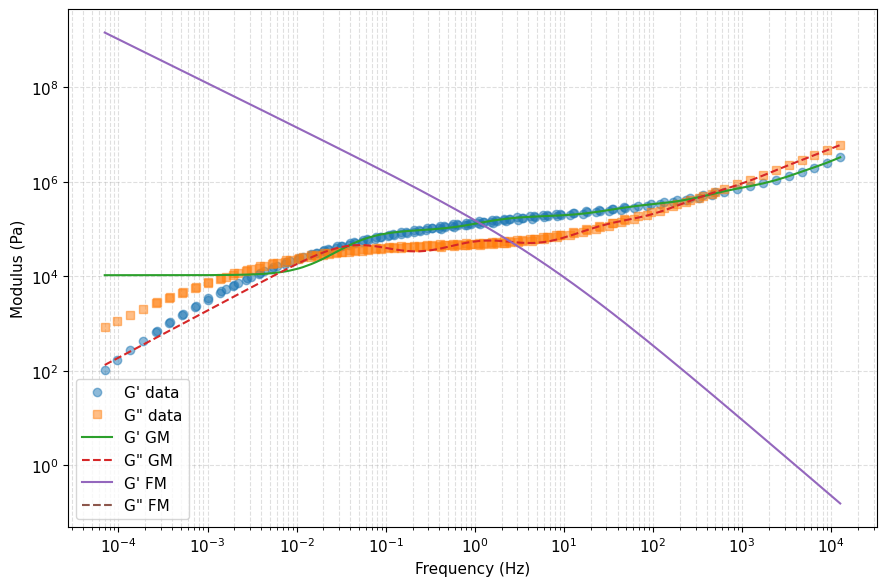

In [5]:
freq_hz = omega/(2*np.pi)
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(gm_pred), '-', label="G' GM")
ax.loglog(freq_hz, np.imag(gm_pred), '--', label='G" GM')
ax.loglog(freq_hz, np.real(fm_pred), '-', label="G' FM")
ax.loglog(freq_hz, np.imag(fm_pred), '--', label='G" FM')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.487167s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.487s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.435887s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.436s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.365083s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=3.937492e+10 | time=0.365s | final_gradient_norm=2.0200867654136484e+16


Element minimization: early termination at n_modes=5 (R²=0.999301 < threshold=0.999499)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.329281s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.099389e+00 | time=0.329s | final_gradient_norm=0.0065040219009454515


Model ranking (R²): [('gm', 1.0), ('fm', -43733.637)]


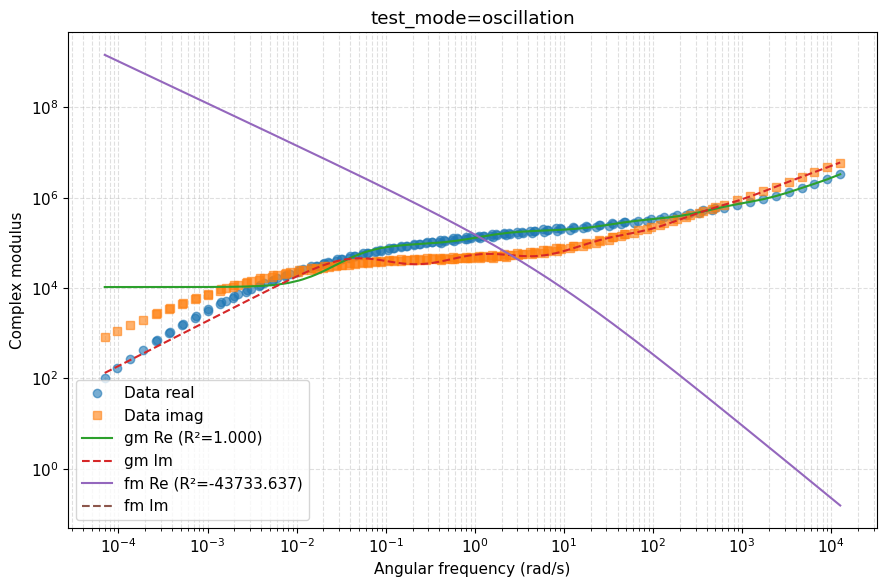

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:01<1:08:53,  1.03s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 28/4000 [00:01<01:58, 33.61it/s, 79 steps of size 2.03e-02. acc. prob=0.72]

warmup:   1%|          | 44/4000 [00:01<01:17, 51.33it/s, 511 steps of size 1.39e-02. acc. prob=0.74]

warmup:   2%|▏         | 60/4000 [00:01<00:57, 68.07it/s, 319 steps of size 1.60e-02. acc. prob=0.75]

warmup:   2%|▏         | 75/4000 [00:01<00:51, 76.49it/s, 255 steps of size 9.46e-03. acc. prob=0.75]

warmup:   2%|▏         | 88/4000 [00:01<00:44, 87.20it/s, 511 steps of size 1.27e-02. acc. prob=0.76]

warmup:   3%|▎         | 124/4000 [00:01<00:26, 147.90it/s, 127 steps of size 7.57e-02. acc. prob=0.77]

warmup:   5%|▌         | 213/4000 [00:01<00:11, 326.79it/s, 31 steps of size 2.04e-01. acc. prob=0.78] 

warmup:   8%|▊         | 310/4000 [00:01<00:07, 491.10it/s, 127 steps of size 1.01e-01. acc. prob=0.78]

warmup:  10%|█         | 411/4000 [00:02<00:05, 628.60it/s, 47 steps of size 2.39e-01. acc. prob=0.79] 

warmup:  13%|█▎        | 516/4000 [00:02<00:04, 743.39it/s, 47 steps of size 3.22e-01. acc. prob=0.79]

warmup:  16%|█▌        | 638/4000 [00:02<00:03, 877.88it/s, 15 steps of size 2.29e-01. acc. prob=0.79]

warmup:  19%|█▉        | 759/4000 [00:02<00:03, 972.24it/s, 15 steps of size 2.97e-01. acc. prob=0.79]

warmup:  22%|██▏       | 874/4000 [00:02<00:03, 1023.87it/s, 15 steps of size 2.46e-01. acc. prob=0.79]

warmup:  25%|██▍       | 986/4000 [00:02<00:02, 1051.97it/s, 31 steps of size 3.07e-01. acc. prob=0.79]

sample:  28%|██▊       | 1105/4000 [00:02<00:02, 1090.60it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  31%|███       | 1227/4000 [00:02<00:02, 1127.99it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  34%|███▎      | 1344/4000 [00:02<00:02, 1139.53it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  36%|███▋      | 1459/4000 [00:02<00:02, 1134.06it/s, 31 steps of size 1.67e-01. acc. prob=0.91]

sample:  39%|███▉      | 1575/4000 [00:03<00:02, 1140.01it/s, 15 steps of size 1.67e-01. acc. prob=0.91]

sample:  42%|████▏     | 1692/4000 [00:03<00:02, 1148.80it/s, 15 steps of size 1.67e-01. acc. prob=0.91]

sample:  45%|████▌     | 1810/4000 [00:03<00:01, 1156.15it/s, 15 steps of size 1.67e-01. acc. prob=0.91]

sample:  48%|████▊     | 1926/4000 [00:03<00:01, 1142.60it/s, 31 steps of size 1.67e-01. acc. prob=0.91]

sample:  51%|█████     | 2043/4000 [00:03<00:01, 1150.67it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  54%|█████▍    | 2159/4000 [00:03<00:01, 1153.43it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  57%|█████▋    | 2276/4000 [00:03<00:01, 1158.03it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  60%|█████▉    | 2392/4000 [00:03<00:01, 1142.24it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  63%|██████▎   | 2513/4000 [00:03<00:01, 1160.45it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  66%|██████▌   | 2631/4000 [00:03<00:01, 1163.78it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  69%|██████▊   | 2748/4000 [00:04<00:01, 1161.69it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  72%|███████▏  | 2865/4000 [00:04<00:00, 1154.49it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  75%|███████▍  | 2983/4000 [00:04<00:00, 1160.57it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  78%|███████▊  | 3100/4000 [00:04<00:00, 1153.72it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  80%|████████  | 3216/4000 [00:04<00:00, 1155.45it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  83%|████████▎ | 3332/4000 [00:04<00:00, 1151.72it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  86%|████████▌ | 3448/4000 [00:04<00:00, 1151.35it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  89%|████████▉ | 3564/4000 [00:04<00:00, 1144.07it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  92%|█████████▏| 3680/4000 [00:04<00:00, 1145.56it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  95%|█████████▍| 3795/4000 [00:04<00:00, 1092.70it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  98%|█████████▊| 3905/4000 [00:05<00:00, 1014.72it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample: 100%|██████████| 4000/4000 [00:05<00:00, 773.49it/s, 31 steps of size 1.67e-01. acc. prob=0.90] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 24/4000 [00:00<00:17, 221.99it/s, 1023 steps of size 8.02e-03. acc. prob=0.70]

warmup:   1%|          | 47/4000 [00:00<00:30, 128.64it/s, 383 steps of size 1.58e-02. acc. prob=0.74] 

warmup:   2%|▏         | 62/4000 [00:00<00:29, 133.70it/s, 767 steps of size 5.58e-03. acc. prob=0.74]

warmup:   2%|▏         | 77/4000 [00:00<00:28, 136.17it/s, 511 steps of size 8.64e-03. acc. prob=0.75]

warmup:   2%|▏         | 92/4000 [00:00<00:29, 132.88it/s, 5 steps of size 5.80e-03. acc. prob=0.76]  

warmup:   3%|▎         | 119/4000 [00:00<00:22, 172.22it/s, 31 steps of size 2.82e-01. acc. prob=0.77]

warmup:   5%|▌         | 217/4000 [00:00<00:09, 407.06it/s, 31 steps of size 3.05e-01. acc. prob=0.78]

warmup:   8%|▊         | 316/4000 [00:00<00:06, 578.09it/s, 19 steps of size 1.59e-01. acc. prob=0.78]

warmup:  11%|█         | 424/4000 [00:01<00:04, 726.23it/s, 31 steps of size 1.90e-01. acc. prob=0.78]

warmup:  13%|█▎        | 526/4000 [00:01<00:04, 812.30it/s, 31 steps of size 1.73e-01. acc. prob=0.79]

warmup:  16%|█▌        | 630/4000 [00:01<00:03, 878.32it/s, 31 steps of size 2.18e-01. acc. prob=0.79]

warmup:  19%|█▉        | 755/4000 [00:01<00:03, 988.51it/s, 15 steps of size 2.56e-01. acc. prob=0.79]

warmup:  22%|██▏       | 879/4000 [00:01<00:02, 1061.66it/s, 15 steps of size 2.81e-01. acc. prob=0.79]

warmup:  25%|██▍       | 987/4000 [00:01<00:02, 1057.86it/s, 15 steps of size 2.91e-01. acc. prob=0.79]

sample:  27%|██▋       | 1094/4000 [00:01<00:02, 1060.16it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  30%|███       | 1206/4000 [00:01<00:02, 1077.72it/s, 31 steps of size 1.53e-01. acc. prob=0.89]

sample:  33%|███▎      | 1315/4000 [00:01<00:02, 1060.53it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  36%|███▌      | 1422/4000 [00:01<00:02, 1062.18it/s, 15 steps of size 1.53e-01. acc. prob=0.91]

sample:  38%|███▊      | 1529/4000 [00:02<00:02, 1056.51it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  41%|████      | 1637/4000 [00:02<00:02, 1062.77it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  44%|████▎     | 1744/4000 [00:02<00:02, 1052.10it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  46%|████▋     | 1851/4000 [00:02<00:02, 1054.86it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  49%|████▉     | 1958/4000 [00:02<00:01, 1058.99it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  52%|█████▏    | 2065/4000 [00:02<00:01, 1062.13it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  54%|█████▍    | 2174/4000 [00:02<00:01, 1070.25it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  57%|█████▋    | 2282/4000 [00:02<00:01, 1056.81it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  60%|█████▉    | 2391/4000 [00:02<00:01, 1065.71it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  62%|██████▏   | 2498/4000 [00:03<00:01, 1057.32it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  65%|██████▌   | 2604/4000 [00:03<00:01, 1052.62it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  68%|██████▊   | 2712/4000 [00:03<00:01, 1058.44it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  70%|███████   | 2818/4000 [00:03<00:01, 1052.61it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  73%|███████▎  | 2924/4000 [00:03<00:01, 1048.48it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  76%|███████▌  | 3029/4000 [00:03<00:00, 1047.84it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  78%|███████▊  | 3137/4000 [00:03<00:00, 1054.79it/s, 15 steps of size 1.53e-01. acc. prob=0.92]

sample:  81%|████████  | 3243/4000 [00:03<00:00, 1055.58it/s, 31 steps of size 1.53e-01. acc. prob=0.90]

sample:  84%|████████▎ | 3349/4000 [00:03<00:00, 1054.69it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  87%|████████▋ | 3461/4000 [00:03<00:00, 1072.85it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  89%|████████▉ | 3569/4000 [00:04<00:00, 1072.01it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  92%|█████████▏| 3677/4000 [00:04<00:00, 1062.26it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  95%|█████████▍| 3784/4000 [00:04<00:00, 1059.09it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  97%|█████████▋| 3893/4000 [00:04<00:00, 1066.51it/s, 15 steps of size 1.53e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 1055.56it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 904.59it/s, 31 steps of size 1.53e-01. acc. prob=0.91] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 29/4000 [00:00<00:14, 264.91it/s, 831 steps of size 4.43e-03. acc. prob=0.70]

warmup:   1%|▏         | 56/4000 [00:00<00:29, 133.24it/s, 255 steps of size 1.32e-02. acc. prob=0.75]

warmup:   2%|▏         | 73/4000 [00:00<00:32, 122.47it/s, 511 steps of size 1.18e-02. acc. prob=0.76]

warmup:   2%|▏         | 87/4000 [00:00<00:34, 114.83it/s, 255 steps of size 1.30e-02. acc. prob=0.76]

warmup:   2%|▎         | 100/4000 [00:00<00:33, 115.02it/s, 7 steps of size 8.21e-03. acc. prob=0.76] 

warmup:   5%|▍         | 185/4000 [00:00<00:12, 304.15it/s, 63 steps of size 1.46e-01. acc. prob=0.78]

warmup:   7%|▋         | 294/4000 [00:01<00:07, 515.05it/s, 31 steps of size 2.21e-01. acc. prob=0.78]

warmup:  10%|█         | 408/4000 [00:01<00:05, 687.67it/s, 15 steps of size 4.01e-01. acc. prob=0.79]

warmup:  13%|█▎        | 514/4000 [00:01<00:04, 790.70it/s, 63 steps of size 1.17e-01. acc. prob=0.78]

warmup:  15%|█▌        | 606/4000 [00:01<00:04, 821.42it/s, 127 steps of size 7.52e-02. acc. prob=0.79]

warmup:  18%|█▊        | 738/4000 [00:01<00:03, 964.03it/s, 15 steps of size 2.89e-01. acc. prob=0.79] 

warmup:  21%|██▏       | 858/4000 [00:01<00:03, 1031.09it/s, 15 steps of size 2.75e-01. acc. prob=0.79]

warmup:  25%|██▍       | 982/4000 [00:01<00:02, 1088.41it/s, 63 steps of size 5.26e-02. acc. prob=0.79]

sample:  27%|██▋       | 1094/4000 [00:01<00:02, 1063.67it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  30%|███       | 1203/4000 [00:01<00:02, 1062.14it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  33%|███▎      | 1311/4000 [00:01<00:02, 1062.33it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  35%|███▌      | 1419/4000 [00:02<00:02, 1061.39it/s, 23 steps of size 1.34e-01. acc. prob=0.93]

sample:  38%|███▊      | 1526/4000 [00:02<00:02, 1060.33it/s, 15 steps of size 1.34e-01. acc. prob=0.93]

sample:  41%|████      | 1633/4000 [00:02<00:02, 1055.92it/s, 15 steps of size 1.34e-01. acc. prob=0.93]

sample:  43%|████▎     | 1739/4000 [00:02<00:02, 1056.68it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  46%|████▌     | 1845/4000 [00:02<00:02, 1054.43it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  49%|████▉     | 1951/4000 [00:02<00:01, 1052.78it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  51%|█████▏    | 2057/4000 [00:02<00:01, 1046.94it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  54%|█████▍    | 2162/4000 [00:02<00:01, 1039.21it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  57%|█████▋    | 2270/4000 [00:02<00:01, 1050.04it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  59%|█████▉    | 2376/4000 [00:02<00:01, 1051.92it/s, 15 steps of size 1.34e-01. acc. prob=0.93]

sample:  62%|██████▏   | 2484/4000 [00:03<00:01, 1059.34it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  65%|██████▍   | 2591/4000 [00:03<00:01, 1062.02it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  67%|██████▋   | 2698/4000 [00:03<00:01, 1053.45it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  70%|███████   | 2804/4000 [00:03<00:01, 1053.97it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  73%|███████▎  | 2910/4000 [00:03<00:01, 1043.84it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  75%|███████▌  | 3019/4000 [00:03<00:00, 1055.67it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  78%|███████▊  | 3125/4000 [00:03<00:00, 1050.08it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  81%|████████  | 3233/4000 [00:03<00:00, 1058.07it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  84%|████████▎ | 3340/4000 [00:03<00:00, 1059.30it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  86%|████████▌ | 3446/4000 [00:03<00:00, 1047.85it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  89%|████████▉ | 3551/4000 [00:04<00:00, 1043.75it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  92%|█████████▏| 3660/4000 [00:04<00:00, 1054.49it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  94%|█████████▍| 3766/4000 [00:04<00:00, 1044.06it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  97%|█████████▋| 3871/4000 [00:04<00:00, 905.80it/s, 31 steps of size 1.34e-01. acc. prob=0.94] 

sample: 100%|█████████▉| 3980/4000 [00:04<00:00, 954.59it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 882.16it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 35/4000 [00:00<00:11, 348.98it/s, 511 steps of size 6.89e-03. acc. prob=0.72]

warmup:   2%|▏         | 70/4000 [00:00<00:24, 161.29it/s, 255 steps of size 1.78e-02. acc. prob=0.76]

warmup:   2%|▏         | 92/4000 [00:00<00:23, 163.24it/s, 127 steps of size 1.42e-02. acc. prob=0.76]

warmup:   3%|▎         | 113/4000 [00:00<00:22, 175.35it/s, 127 steps of size 1.19e-01. acc. prob=0.77]

warmup:   5%|▌         | 201/4000 [00:00<00:10, 369.99it/s, 63 steps of size 1.31e-01. acc. prob=0.78] 

warmup:   8%|▊         | 316/4000 [00:00<00:06, 588.61it/s, 63 steps of size 1.17e-01. acc. prob=0.78]

warmup:  11%|█         | 444/4000 [00:00<00:04, 787.02it/s, 15 steps of size 1.63e-01. acc. prob=0.79]

warmup:  14%|█▎        | 546/4000 [00:01<00:04, 853.99it/s, 15 steps of size 1.30e-01. acc. prob=0.79]

warmup:  17%|█▋        | 675/4000 [00:01<00:03, 979.23it/s, 31 steps of size 1.60e-01. acc. prob=0.79]

warmup:  20%|██        | 800/4000 [00:01<00:03, 1057.89it/s, 31 steps of size 2.25e-01. acc. prob=0.79]

warmup:  23%|██▎       | 930/4000 [00:01<00:02, 1128.95it/s, 15 steps of size 2.29e-01. acc. prob=0.79]

sample:  26%|██▌       | 1046/4000 [00:01<00:02, 1082.17it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  29%|██▉       | 1157/4000 [00:01<00:02, 1080.11it/s, 31 steps of size 1.56e-01. acc. prob=0.95]

sample:  32%|███▏      | 1267/4000 [00:01<00:02, 1070.94it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  34%|███▍      | 1376/4000 [00:01<00:02, 1068.93it/s, 7 steps of size 1.56e-01. acc. prob=0.94] 

sample:  37%|███▋      | 1484/4000 [00:01<00:02, 1064.05it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  40%|███▉      | 1591/4000 [00:01<00:02, 1056.70it/s, 15 steps of size 1.56e-01. acc. prob=0.94]

sample:  42%|████▏     | 1698/4000 [00:02<00:02, 1056.64it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  45%|████▌     | 1804/4000 [00:02<00:02, 1049.24it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  48%|████▊     | 1910/4000 [00:02<00:02, 1039.78it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  50%|█████     | 2016/4000 [00:02<00:01, 1044.82it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  53%|█████▎    | 2121/4000 [00:02<00:01, 1033.04it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  56%|█████▌    | 2226/4000 [00:02<00:01, 1037.35it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  58%|█████▊    | 2332/4000 [00:02<00:01, 1042.14it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  61%|██████    | 2442/4000 [00:02<00:01, 1058.57it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  64%|██████▎   | 2548/4000 [00:02<00:01, 1054.85it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  66%|██████▋   | 2654/4000 [00:02<00:01, 1049.53it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  69%|██████▉   | 2762/4000 [00:03<00:01, 1057.77it/s, 15 steps of size 1.56e-01. acc. prob=0.94]

sample:  72%|███████▏  | 2868/4000 [00:03<00:01, 1055.76it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  74%|███████▍  | 2975/4000 [00:03<00:00, 1058.74it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  77%|███████▋  | 3081/4000 [00:03<00:00, 1053.88it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  80%|███████▉  | 3187/4000 [00:03<00:00, 1052.27it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  82%|████████▏ | 3295/4000 [00:03<00:00, 1058.00it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  85%|████████▌ | 3401/4000 [00:03<00:00, 1038.11it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  88%|████████▊ | 3505/4000 [00:03<00:00, 1035.14it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  90%|█████████ | 3612/4000 [00:03<00:00, 1044.90it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  93%|█████████▎| 3717/4000 [00:03<00:00, 1044.95it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  96%|█████████▌| 3825/4000 [00:04<00:00, 1052.25it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  98%|█████████▊| 3931/4000 [00:04<00:00, 1046.52it/s, 15 steps of size 1.56e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 936.34it/s, 31 steps of size 1.56e-01. acc. prob=0.94] 

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='sigma_real'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>, <Axes: xlabel='E_5'>,
        <Axes: xlabel='E_6'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigm

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (60) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_5\n0'}>,
        <Axes: title={'center': 'E_5\n1'}>,
        <Axes: title={'center': 'E_5\n2'}>,
        <Axes: title={'center': 'E_5\n3'}>],
       [<Axes: title={'center': 'E_6\n0'}>,
        <Axes: title={'center': 'E_6\n1'}>,
        <Axes: title={'cent

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_6'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_3'}, 

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_6'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics
import arviz as az

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
